In [1]:
import os
import random 
import re
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud

In [2]:
# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

In [3]:
Le = LabelEncoder()
lemme = WordNetLemmatizer()
stop_words_nltk = set(stopwords.words('english'))

In [4]:
df =pd.read_csv('D:/Repos_git/depression_suicide_project/Pretrained_embedding_models/dataset/English_textbook_NCBI_9_10.csv')

In [5]:
df.head()

,Unnamed: 0,lessons,processed
0,0,The aim of secondary education is to make the ...,aim secondary education learner fit entry high...
1,1,The Tale of Homecoming\n \n Bangabandhu's Home...,tale homecoming bangabandhu homecoming january...
2,2,Bangabandhu at the UN\n 1\tED\tTIO\tS\n A...,bangabandhu tio work pair discuss follow quest...
3,3,Have You anyFavourite Pastime?\n A\tLook at th...,anyfavourite pastime look picture person dothe...
4,4,Change in Pastime\n A\tRead the text.\n Childh...,change pastime read text childhood outdoor pas...


In [11]:
def gen_wordcloud():
    col_name = df.processed.values.tolist()
    text = ' '.join(col_name)
    wc = WordCloud(width = 1000, height = 500, background_color = "white", 
                   colormap = "magma", max_words = 100)
    wc.generate(text)

    plt.axis("off")
    plt.imshow(wc, interpolation = "bilinear")


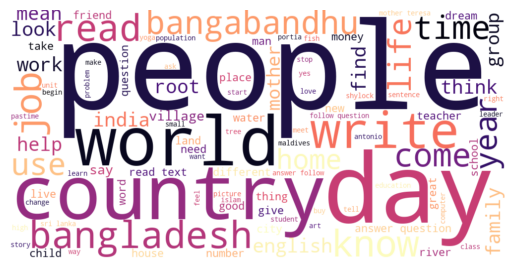

In [12]:
gen_wordcloud()

### Model building (Step 4)
#### The next step is to train the unsupervised machine learning model on the data. 
#### LdaMulticore, which uses all CPU cores to parallelize and speed up model training. 
#### Tried gensim.models.ldamodel.LdaModel class which is an equivalent, but single-core implementation.

In [6]:
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

from pprint import pprint

import spacy

import pickle
import re
import pyLDAvis
import pyLDAvis.gensim


## https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
# Our spaCy model:
nlp = en_core_web_md.load()

In [8]:
# Tags I want to remove from the text
removal= ['DET','ADP','SPACE', 'NUM', 'SYM', 'AUX', 'PRON','CCONJ','PUNCT','PART']

In [9]:
def prepare_tokens_pyldvis(dataset):
    tok = []
    for summary in nlp.pipe(dataset['processed']):
        proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
        tok.append(proj_tok)
    return tok


def remove_noisy_features(tok):
    # remove words less than 3 characters
    collect_text = []
    collector = []
    for items in tok:
        for i in items:
            if len(i) > 2:
                collect_text.append(i)
        collector.append(collect_text)
        collect_text = []
    return collector

def prepare_lda_model(dataset, toks):
    # Add tokens to new column
    dataset['tokens'] = toks
    dic = Dictionary(dataset['tokens'])
    #     print(dictionary.token2id)
    # Filter dictionary
    dic.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
    # Create corpus
    corp = [dic.doc2bow(doc) for doc in dataset['tokens']]
    # LDA model building
    lda_mod = LdaMulticore(corpus=corp, id2word=dic, iterations=10, num_topics=10, workers = 4, passes=10)
    return corp, lda_mod, dic

In [69]:
[[(id2word[i], freq) for i, freq in doc] for doc in corpus[:1]]

NameError: name 'id2word' is not defined

In [17]:
# coherence ({'u_mass', 'c_v', 'c_uci', 'c_npmi'}, optional) – Coherence measure to be used. 
# Fastest method - ‘u_mass’, ‘c_uci’ also known as c_pmi. For ‘u_mass’ corpus should be provided, 
# if texts is provided, it will be converted to corpus using the dictionary. 
# For ‘c_v’, ‘c_uci’ and ‘c_npmi’ texts should be provided (corpus isn’t needed)

def get_coherence_score(corp, dataset, dic):
    # Coherence score using C_umass:
    topics = []
    score = []
    for i in range(1,15,1):
        lda_model = LdaMulticore(corpus=corp, id2word=dic, iterations=20, num_topics=i, workers = 4, passes=10, random_state=100)
        cm = CoherenceModel(model=lda_model, corpus=corp, dictionary=dic, coherence='u_mass')
        topics.append(i)
        score.append(cm.get_coherence())
    _=plt.plot(topics, score)
    _=plt.xlabel('Number of Topics')
    _=plt.ylabel('Coherence Score')
    plt.show()

    # Coherence score using C_v:
    topics = []
    score = []
    for i in range(1,15,1):
        lda_model = LdaMulticore(corpus=corp, id2word=dic, iterations=20, num_topics=i, workers = 4, passes=10, random_state=100)
        cm = CoherenceModel(model=lda_model, texts = dataset['tokens'], corpus=corp, dictionary=dic, coherence='c_v')
        topics.append(i)
        score.append(cm.get_coherence())
    _=plt.plot(topics, score)
    _=plt.xlabel('Number of Topics')
    _=plt.ylabel('Coherence Score')
    plt.show()

In [19]:
# c_npmi, c_uci both category showed negetive coherence like u_mass hence not aken into consideraion for analysis
def get_coherence_score_npmi(corp, dataset, dic):
    # Coherence score using C_v:
    topics = []
    score = []
    for i in range(1,15,1):
        lda_model = LdaMulticore(corpus=corp, id2word=dic, iterations=20, num_topics=i, workers = 4, passes=10, random_state=100)
        cm = CoherenceModel(model=lda_model, texts = dataset['tokens'], corpus=corp, dictionary=dic, coherence='c_uci')
        topics.append(i)
        score.append(cm.get_coherence())
    _=plt.plot(topics, score)
    _=plt.xlabel('Number of Topics')
    _=plt.ylabel('Coherence Score')
    plt.show()



In [ ]:
# get_coherence_score_npmi(corpus, ind, dictionary)

In [10]:
# For indicator
tokens = prepare_tokens_pyldvis(df)
tokens = remove_noisy_features(tokens)
corpus, lda_model, dictionary = prepare_lda_model(df, tokens)

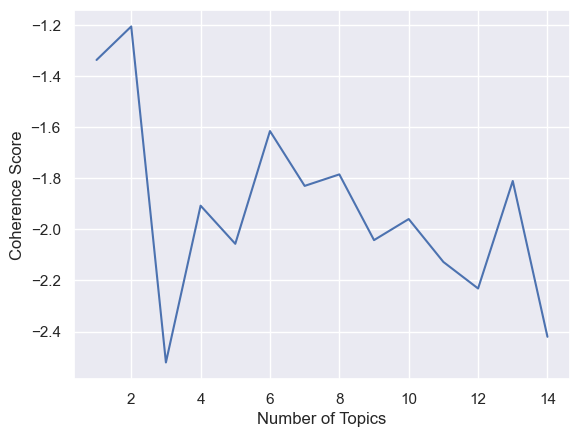

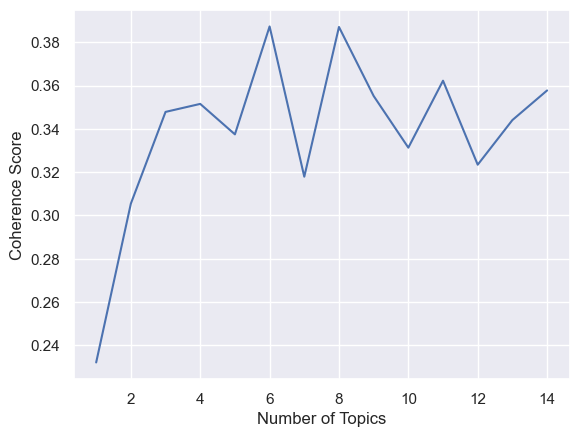

In [23]:
# For indicator
tokens = prepare_tokens_pyldvis(df)
tokens = remove_noisy_features(tokens)
corpus, lda_model, dictionary = prepare_lda_model(df, tokens)
get_coherence_score(corpus, df, dictionary)

In [11]:
# Optimal model
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=20, num_topics=6, workers = 4, passes=100)


In [45]:
print('Topic: 01')
j=2
for items, k in lda_model.print_topics():
    x = k.split('+')
    
    for i in x:
        y=i.split('*')
        print(f"{y[1]}{y[0]},", end=" ")
#         print(y[1],y[0], end=" ")
    print('Topic: ',j)
    j=j+1    

Topic: 01
"energy" 0.060, "source"  0.029, "renewable"  0.018, "water"  0.016, "use"  0.013, "gas"  0.013, "produce"  0.013, "green"  0.013, "warm"  0.013, "cause" 0.012, Topic:  2
"pastime" 0.024, "computer"  0.024, "social"  0.023, "user"  0.022, "network"  0.020, "student"  0.019, "class"  0.017, "change"  0.016, "book"  0.015, "survey" 0.013, Topic:  3
"mother" 0.083, "buy"  0.021, "love"  0.018, "child"  0.014, "worker"  0.014, "begin"  0.013, "cultural"  0.012, "observe"  0.012, "thing"  0.012, "language" 0.011, Topic:  4
"life" 0.016, "bangladesh"  0.016, "family"  0.015, "home"  0.014, "root"  0.014, "language"  0.014, "country"  0.013, "pakistan"  0.010, "war"  0.010, "man" 0.009, Topic:  5
"country" 0.031, "river"  0.022, "india"  0.022, "land"  0.021, "boat"  0.015, "small"  0.015, "population"  0.015, "lake"  0.013, "group"  0.012, "house" 0.011, Topic:  6
"job" 0.064, "english"  0.023, "learn"  0.021, "teacher"  0.017, "use"  0.016, "dream"  0.016, "think"  0.016, "thing" 

In [12]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())


[(0,
  '0.060*"energy" + 0.029*"source" + 0.018*"renewable" + 0.016*"water" + '
  '0.013*"use" + 0.013*"gas" + 0.013*"produce" + 0.013*"green" + 0.013*"warm" '
  '+ 0.012*"cause"'),
 (1,
  '0.024*"pastime" + 0.024*"computer" + 0.023*"social" + 0.022*"user" + '
  '0.020*"network" + 0.019*"student" + 0.017*"class" + 0.016*"change" + '
  '0.015*"book" + 0.013*"survey"'),
 (2,
  '0.083*"mother" + 0.021*"buy" + 0.018*"love" + 0.014*"child" + '
  '0.014*"worker" + 0.013*"begin" + 0.012*"cultural" + 0.012*"observe" + '
  '0.012*"thing" + 0.011*"language"'),
 (3,
  '0.016*"life" + 0.016*"bangladesh" + 0.015*"family" + 0.014*"home" + '
  '0.014*"root" + 0.014*"language" + 0.013*"country" + 0.010*"pakistan" + '
  '0.010*"war" + 0.009*"man"'),
 (4,
  '0.031*"country" + 0.022*"river" + 0.022*"india" + 0.021*"land" + '
  '0.015*"boat" + 0.015*"small" + 0.015*"population" + 0.013*"lake" + '
  '0.012*"group" + 0.011*"house"'),
 (5,
  '0.064*"job" + 0.023*"english" + 0.021*"learn" + 0.017*"teacher" + 

In [46]:
# Visualize topics
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
# pyLDAvis.display(lda_display)


In [48]:
# Save the report
file_path = 'D:/Repos_git/depression_suicide_project/papers/NLP based learning/NCBI_result/lda_display.html'
pyLDAvis.save_html(lda_display, file_path)

### Experiments with coherence topic modeling End Here

### https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In [28]:
from matplotlib.ticker import FuncFormatter

### What are the most discussed topics in the documents?
### Let’s compute the total number of documents attributed to each topic.

In [118]:
# Let’s make two plots:
# The number of documents for each topic by assigning the document to the topic that has the most weight in that document.
# The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents

In [51]:
from gensim.utils import simple_preprocess
import matplotlib.colors as mcolors

In [52]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])


In [53]:
tokens = prepare_tokens_pyldvis(df)
tokens = remove_noisy_features(tokens)

In [54]:
data_words = tokens

In [55]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [56]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

In [141]:
# When it comes to the keywords in the topics, the importance (weights) of the keywords matters. 
# Along with that, how frequently the words have appeared in the documents is also interesting to look.

# Let’s plot the word counts and the weights of each keyword in the same chart.
# the words that occur in multiple topics and the ones whose relative frequency is more than the weight. 
# Often such words turn out to be less important.

In [57]:
lda_model.show_topics(formatted=False)

[(0,
  [('energy', 0.0599027),
   ('source', 0.028827805),
   ('renewable', 0.017656377),
   ('water', 0.015638204),
   ('use', 0.013460913),
   ('gas', 0.013407314),
   ('produce', 0.013402845),
   ('green', 0.013079888),
   ('warm', 0.012558292),
   ('cause', 0.011906094)]),
 (1,
  [('pastime', 0.024200594),
   ('computer', 0.023634015),
   ('social', 0.02308874),
   ('user', 0.022179281),
   ('network', 0.019805206),
   ('student', 0.018513966),
   ('class', 0.017061992),
   ('change', 0.01623511),
   ('book', 0.015224401),
   ('survey', 0.013361179)]),
 (2,
  [('mother', 0.08274698),
   ('buy', 0.02066794),
   ('love', 0.01804408),
   ('child', 0.014052793),
   ('worker', 0.013927079),
   ('begin', 0.013198489),
   ('cultural', 0.012412466),
   ('observe', 0.012364727),
   ('thing', 0.012128099),
   ('language', 0.0106991045)]),
 (3,
  [('life', 0.0164498),
   ('bangladesh', 0.016234053),
   ('family', 0.014729757),
   ('home', 0.014321123),
   ('root', 0.014056006),
   ('language'

C:\Users\Teacher\AppData\Local\Temp\ipykernel_14212\4181556215.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


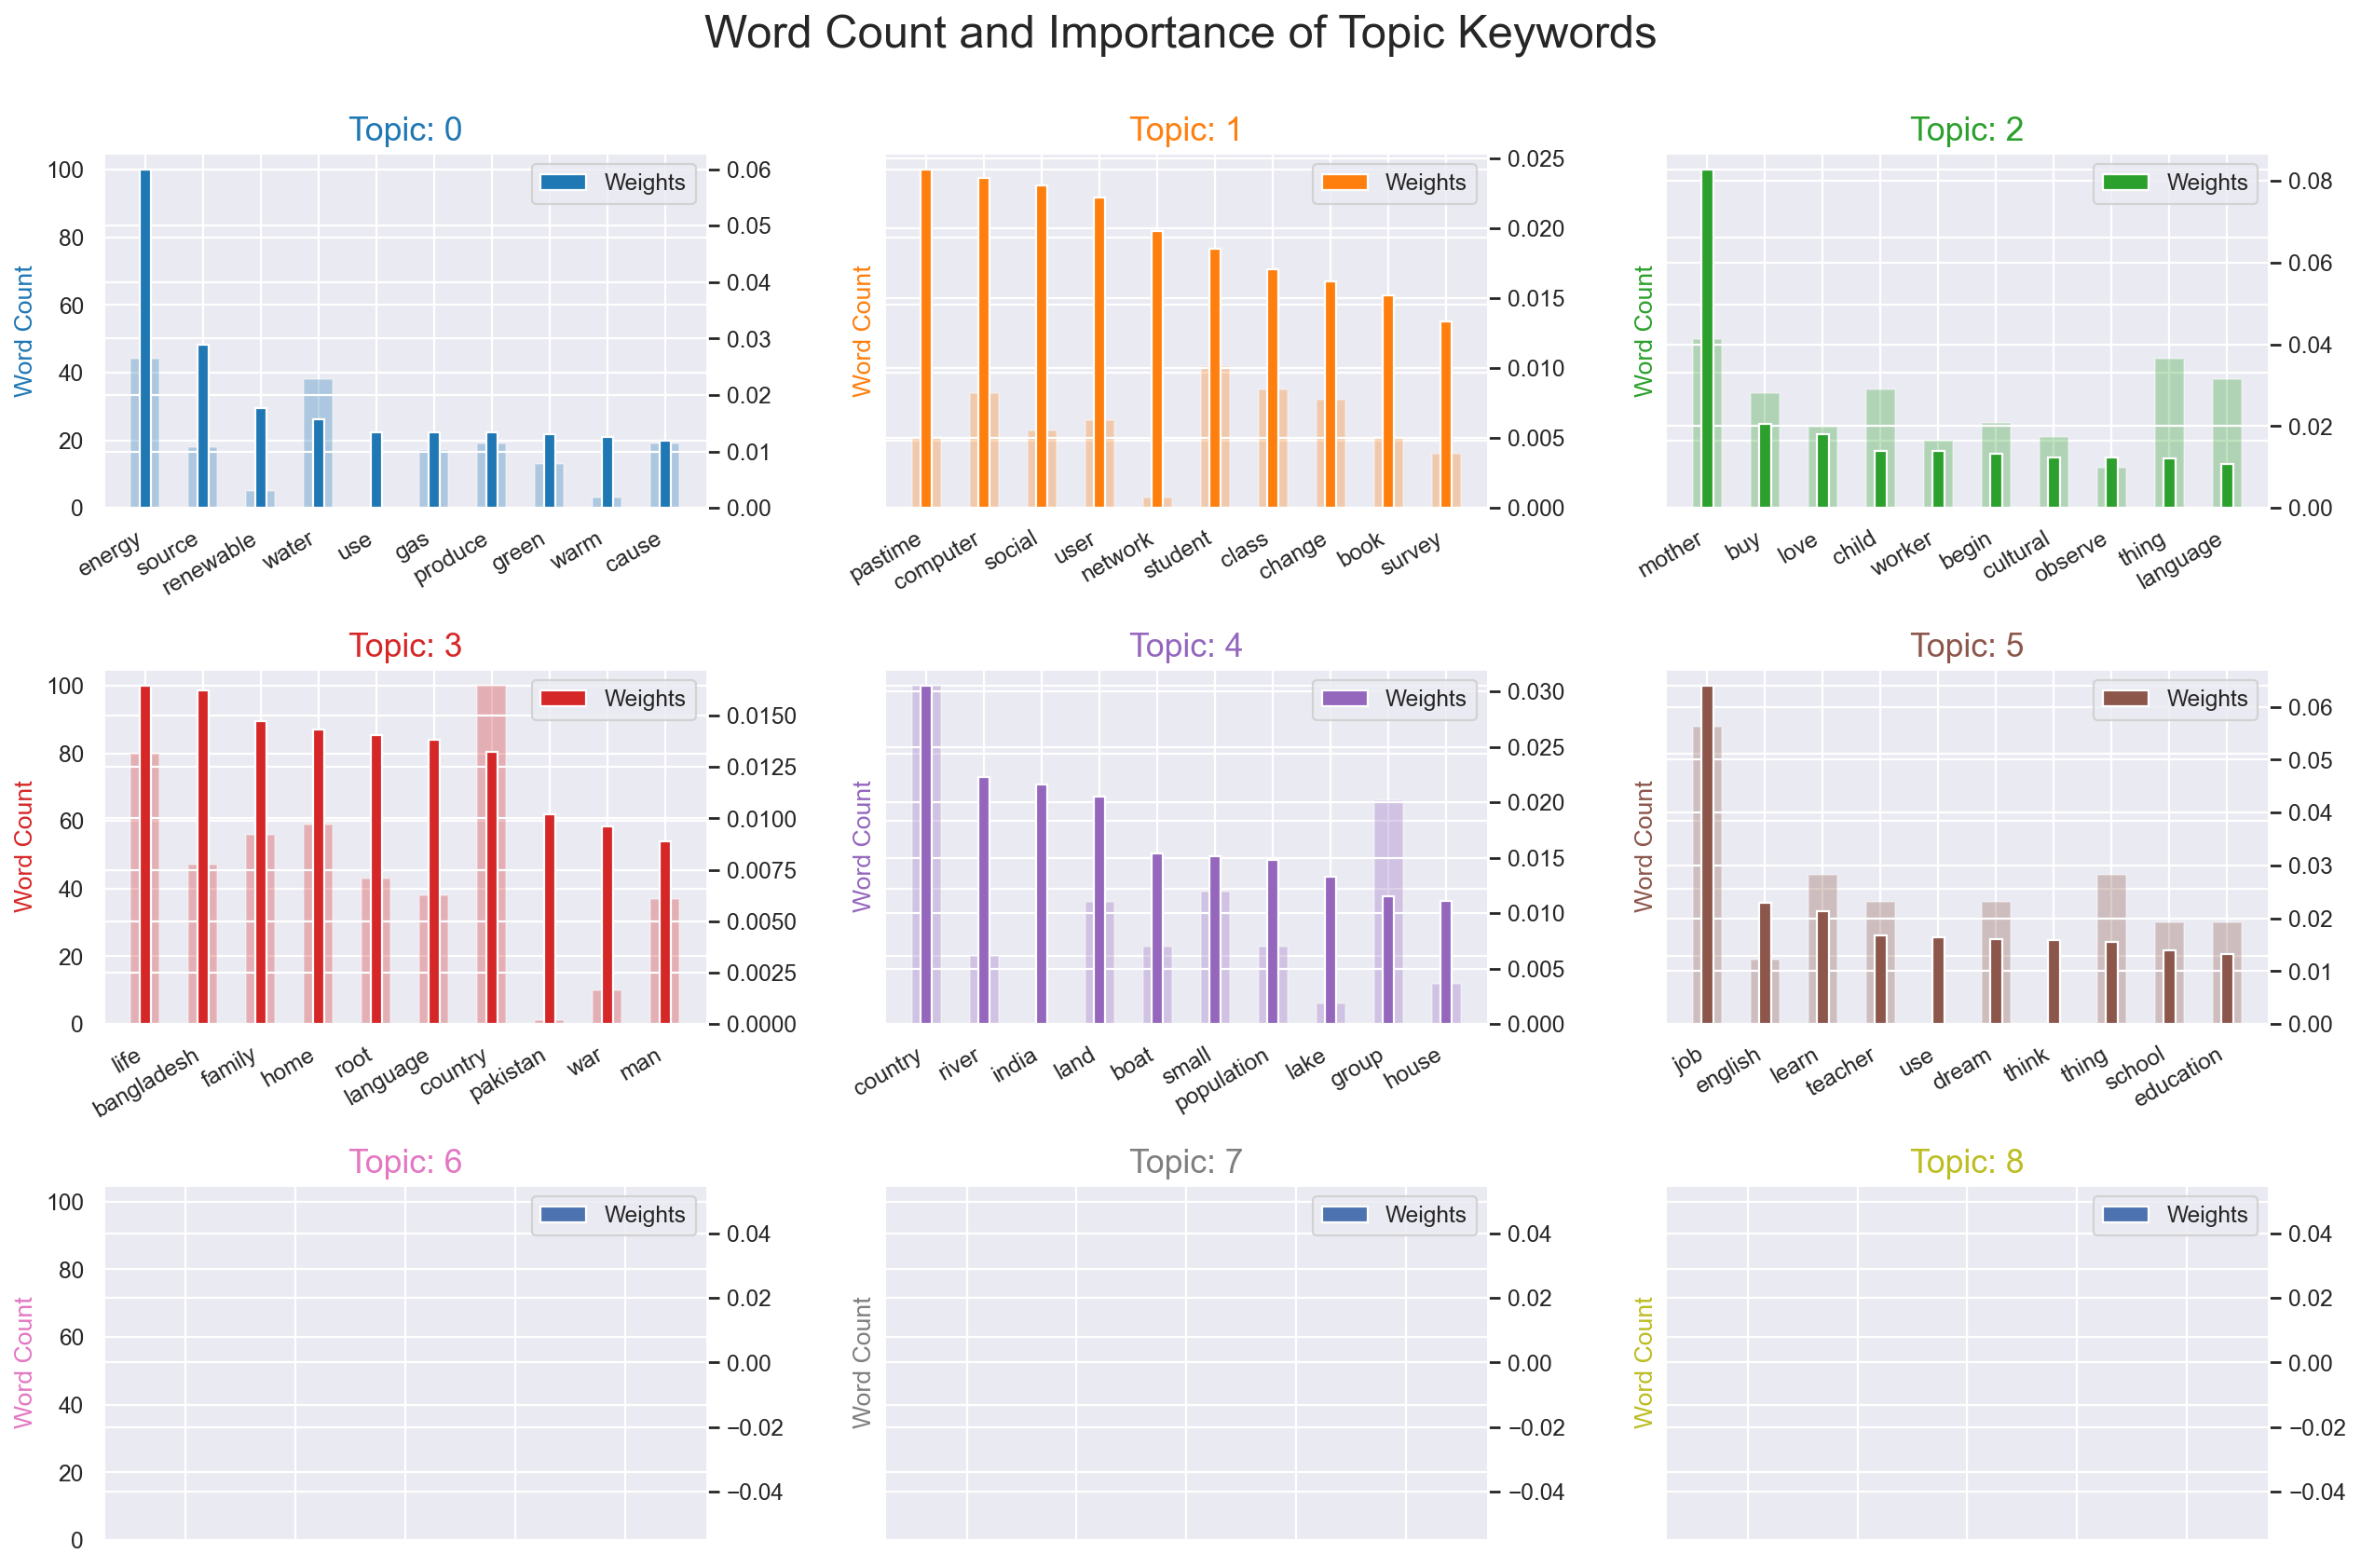

In [59]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3) #label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
#     ax_twin.set_ylim(0, 0.050); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
#     ax.legend(loc='upper left'); 
    ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()